In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter, GlobalObjective
from refnx.reflect import SLD, Slab, ReflectModel, LipidLeaflet
# from sepObjectiveGO import getObjective as gO
from dynesty import DynamicNestedSampler
from dynesty import plotting as dyplot
from CFitter import CFitter
# import make_sim_data as msd
# import lipidBilayerAsGiven.SLD_maker 
import data_in as di
import lipidBilayerAsGiven.Bilayer as bl
import lipidBilayerAsGiven.Popg as Pg
import lipidBilayerAsGiven.Popc as Pc
import lipidBilayerAsGiven.Dodab as ml

print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))
%matplotlib inline
SEED = 12345
figI = 0

refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


csv
cvs-collecting
csv
cvs-collecting


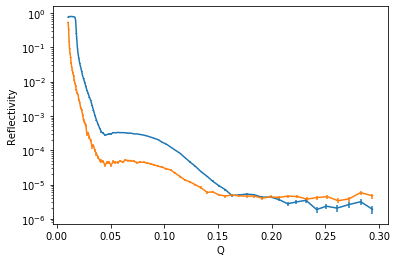

In [2]:
dataD2o = Data1D(data=di.data_in("lipidBilayerData/54696_97_edit.txt"))
dataD2o.name="d2o"
dataPmw = Data1D(data=di.data_in("lipidBilayerData/54699_00_edit.txt"))
dataPmw.name="pmw"

plt.errorbar(dataD2o.data[0],dataD2o.data[1],dataD2o.data[2])
plt.errorbar(dataPmw.data[0],dataPmw.data[1],dataPmw.data[2])
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.yscale("log")
plt.show()

In [3]:
d2o = SLD(6.07, "D2O")
pmw = SLD(2.35, "Protein Matched Water")
air = SLD(0.00, "Air")

p_Popc = Pc.Popc(pmw)
p_Popg = Pg.Popg(pmw)

d_Popc = Pc.Popc(d2o)
d_Popg = Pg.Popg(d2o)

bilayer_d2o = bl.Bilayer(d_Popc, d_Popg)
bilayer_pmw = bl.Bilayer(p_Popc, p_Popg)

bilayer_d2o2 = bl.Bilayer(Pc.Popc(d2o),Pg.Popg(d2o), name="Bilayer2")
bilayer_pmw2 = bl.Bilayer(Pc.Popc(pmw),Pg.Popg(pmw), name="Bilayer2")

dodab_d2o = ml.Dodab(d2o)
dodab_pmw = ml.Dodab(pmw)

In [4]:
structure_d2o = air(0, 0) | dodab_d2o | d2o(0, 0) | bilayer_d2o | d2o(0, 0) | bilayer_d2o2 | d2o(0, 0)
structure_pmw = air(0, 0) | dodab_pmw | pmw(0, 0) | bilayer_pmw | pmw(0, 0) | bilayer_pmw2 | pmw(0, 0)

d2o.real.setp(6.07, vary=True, bounds=(5.35, 6.35))
pmw.real.setp(2.34, vary=True, bounds=(1.35, 3.35))
structure_d2o[2].thick.setp(14.3, vary=True, bounds=(6, 20))
structure_d2o[2].rough.setp(4.6, vary=True, bounds=(3, 20))

In [5]:

model1 = ReflectModel(structure_d2o)
model1.scale.setp(0.75, vary=True, bounds=(0.5, 1.5))
model1.bkg.setp(dataD2o.y.min(),vary=True,bounds=(dataD2o.y.min() * 0.2, dataD2o.y.min() * 1.8))

model2 = ReflectModel(structure_pmw)
model2.scale.setp(0.75, vary=True, bounds=(0.5, 1.5))
model2.bkg.setp(dataPmw.y.min(),vary=True,bounds=(dataPmw.y.min() * 0.2, dataPmw.y.min() * 1.8))

objective1 = Objective(model1, dataD2o)#, transform=Transform("logY"))
objective2 = Objective(model2, dataPmw)#, transform=Transform("logY"))
gobjective = GlobalObjective([objective1,objective2])

# if True:
#     fitter = CurveFitter(gobjective)
#     fitter.fit("differential_evolution", target="nlpost")#, seed=SEED)
    # fitter.sample(200, random_state=SEED)
    # fitter.sampler.reset()
    # fitter.sample(200, random_state=SEED,
    #             f="lipidBilayerAsGiven/outputs/nbilayer_chain.txt")
    # file_o = open('lipidBilayerAsGiven/outputs/nbilayer.txt', 'w')
    # file_o.write("{}".format(gobjective))
    # file_o.close()

In [6]:
fitter = CFitter(gobjective)
DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
DNSampler.run_nested(dlogz_init=0.05) # was 0.01
res11 = DNSampler.results

2002it [16:21,  5.56s/it, batch: 0 | bound: 5 | nc: 944 | ncall: 173941 | eff(%):  1.148 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.050] 

Exception while calling loglikelihood function:
  params: [5.38993554e-01 5.63524968e-07 7.50248619e+00 1.04962986e+02
 3.78336649e+00 1.28227617e+01 6.02190932e+00 4.32883163e+00
 3.27915301e+00 2.26797284e+00 9.43077447e+01 1.33572974e+01
 1.27289233e+01 4.02953653e+00 3.31993937e+00 1.00419178e+02
 1.69786976e+01 4.35092453e+00 5.31431365e-01 4.74127409e-06
 1.16214798e+01 1.10586077e+02 6.19277334e+00 2.27803534e+00
 4.89881334e+00 9.28376437e-01 1.20976394e+02 9.38703605e+00
 8.96061787e+00 2.44215961e+00 4.71257390e+00 6.39926595e+01
 5.48649342e+00 1.48744130e+01]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\dynesty.py", line 860, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "C:\Users\John\Documents\programing\mphys\CFitter.py", line 61, in logl
    return self.objective.logl(pvalues)#self.pValues)
  File "C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\refnx\analysis\objective.py", line 936, in logl
    logl += objective.logl()
  File "C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\refnx\analysis\objective.py", line 526, in logl
    model = self.model(self.data.x, x_err=self.data.x_err)
  File "C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\refnx\reflect\reflect_model.py", line 183, in __call__
    return self.model(x, p=p, x_err=x_err)
  File "C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\refnx\reflect\reflect_model.py", line 267, in model
    quad_order=self.quad_order)
  File "C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\refnx\

KeyboardInterrupt: 

In [ ]:
fig, ax = gobjective.plot()
plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
figI+=1
plt.figure(figI)
figI+=1
plt.plot(*structure1.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

In [ ]:
# span = [(0,5000),(0,1.5),(0,0.4),(-10**1,10**1)]
# fig, axes = dyplot.runplot(res11,span=span, color='black', mark_final_live=False,
#                            logplot=False)
# fig.tight_layout()

In [ ]:
fig, axes = dyplot.traceplot(res11, #truths=np.zeros(fitter.nDim()),
                             show_titles=True, trace_cmap='plasma',
                             quantiles=None)
fig.tight_layout()